In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# XGBoost (pip install xgboost if needed)
from xgboost import XGBClassifier

import seaborn as sns  # only for nicer plots; remove if you prefer pure matplotlib
import joblib
import os
os.makedirs("figures", exist_ok=True)

In [4]:
df = pd.read_csv("ai_human_content_detection_dataset.csv")
print(df.shape)
df.head(3)

(1367, 17)


,text_content,content_type,word_count,character_count,sentence_count,lexical_diversity,avg_sentence_length,avg_word_length,punctuation_ratio,flesch_reading_ease,gunning_fog_index,grammar_errors,passive_voice_ratio,predictability_score,burstiness,sentiment_score,label
0,Score each cause. Quality throughout beautiful...,academic_paper,288,1927,54,0.9514,5.33,5.69,0.0280,53.08,7.41,1,0.1041,105.86,0.5531,0.2034,1
1,Board its rock. Job worker break tonight coupl...,essay,253,1719,45,0.9723,5.62,5.80,0.0262,50.32,8.10,6,0.2045,100.29,0.5643,0.4854,1
2,Way debate decision produce. Dream necessary c...,academic_paper,420,2849,75,0.9071,5.60,5.79,0.0263,46.86,7.86,5,0.2308,96.88,0.4979,-0.2369,1


In [6]:
LABEL_COL = "label"
CAT_COLS = ["content_type"]
# all numeric columns except label/text/categorical
NUM_COLS = [
    c for c in df.columns
    if c not in [LABEL_COL, "text_content"] + CAT_COLS
    and pd.api.types.is_numeric_dtype(df[c])
]

X = df[NUM_COLS + CAT_COLS].copy()
y = df[LABEL_COL].astype(int).values

print("Numeric features:", NUM_COLS)
print("Categorical features:", CAT_COLS)
print("Target distribution:", pd.Series(y).value_counts(normalize=True).round(3))

Numeric features: ['word_count', 'character_count', 'sentence_count', 'lexical_diversity', 'avg_sentence_length', 'avg_word_length', 'punctuation_ratio', 'flesch_reading_ease', 'gunning_fog_index', 'grammar_errors', 'passive_voice_ratio', 'predictability_score', 'burstiness', 'sentiment_score']
Categorical features: ['content_type']
Target distribution: 0    0.5
1    0.5
Name: proportion, dtype: float64


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape

((1093, 15), (274, 15))

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUM_COLS),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), CAT_COLS),
    ],
    remainder="drop"
)

# Fit on training data only, then transform both train/test
preprocessor.fit(X_train)
Xtr = preprocessor.transform(X_train)
Xte = preprocessor.transform(X_test)

# Get feature names after transformation for plotting importances later
num_names = NUM_COLS
cat_names = preprocessor.named_transformers_["cat"].get_feature_names_out(CAT_COLS).tolist()
feature_names = list(num_names) + list(cat_names)
len(feature_names), feature_names[:5]

(21,
 ['word_count',
  'character_count',
  'sentence_count',
  'lexical_diversity',
  'avg_sentence_length'])

In [16]:
from sklearn.impute import SimpleImputer

# 1. Create imputer to fill NaNs with 0
imputer = SimpleImputer(strategy="constant", fill_value=0)

# 2. Fit the imputer on training data, transform both train and test
Xtr = imputer.fit_transform(Xtr)
Xte = imputer.transform(Xte)

# 3. Fit each model on the cleaned data
fitted = {}
for name, model in models.items():
    model.fit(Xtr, y_train)
    fitted[name] = model

In [17]:
rows = []
for name, model in fitted.items():
    pred = model.predict(Xte)
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred, zero_division=0)
    rec = recall_score(y_test, pred, zero_division=0)
    f1 = f1_score(y_test, pred, zero_division=0)
    rows.append([name, acc, prec, rec, f1])
    print(f"\n=== {name} ===")
    print("Accuracy:", round(acc, 4))
    print(classification_report(y_test, pred, digits=3))

metrics_df = pd.DataFrame(rows, columns=["Model","Accuracy","Precision","Recall","F1"])
metrics_df.sort_values("Accuracy", ascending=False, inplace=True)
metrics_df


=== LogisticRegression ===
Accuracy: 0.5
              precision    recall  f1-score   support

           0      0.500     0.511     0.505       137
           1      0.500     0.489     0.494       137

    accuracy                          0.500       274
   macro avg      0.500     0.500     0.500       274
weighted avg      0.500     0.500     0.500       274


=== RandomForest ===
Accuracy: 0.5073
              precision    recall  f1-score   support

           0      0.506     0.599     0.548       137
           1      0.509     0.416     0.458       137

    accuracy                          0.507       274
   macro avg      0.508     0.507     0.503       274
weighted avg      0.508     0.507     0.503       274


=== XGBoost ===
Accuracy: 0.5182
              precision    recall  f1-score   support

           0      0.516     0.577     0.545       137
           1      0.521     0.460     0.488       137

    accuracy                          0.518       274
   macro avg 

,Model,Accuracy,Precision,Recall,F1
2,XGBoost,0.518248,0.520661,0.459854,0.488372
1,RandomForest,0.507299,0.508929,0.416058,0.457831
0,LogisticRegression,0.500000,0.500000,0.489051,0.494465


In [20]:
metrics_df.to_csv("model_metrics.csv", index=False)
metrics_df

,Model,Accuracy,Precision,Recall,F1
2,XGBoost,0.518248,0.520661,0.459854,0.488372
1,RandomForest,0.507299,0.508929,0.416058,0.457831
0,LogisticRegression,0.500000,0.500000,0.489051,0.494465


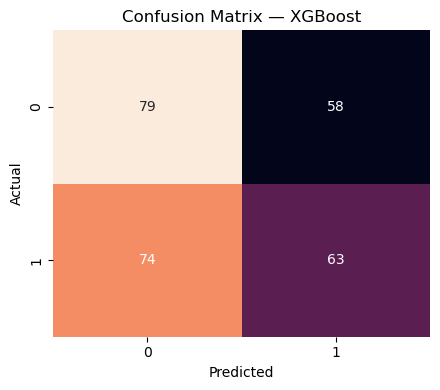

In [22]:
best_name = metrics_df.iloc[0]["Model"]
best_model = fitted[best_name]
best_pred = best_model.predict(Xte)

cm = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(4.5,4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title(f"Confusion Matrix — {best_name}")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.savefig("figures/confusion_matrix.png", dpi=150)
plt.show()

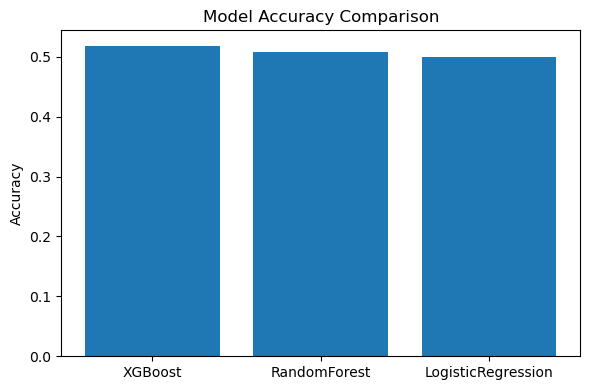

In [24]:
plt.figure(figsize=(6,4))
plt.bar(metrics_df["Model"], metrics_df["Accuracy"])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.tight_layout(); plt.savefig("figures/model_accuracy.png", dpi=150)
plt.show()

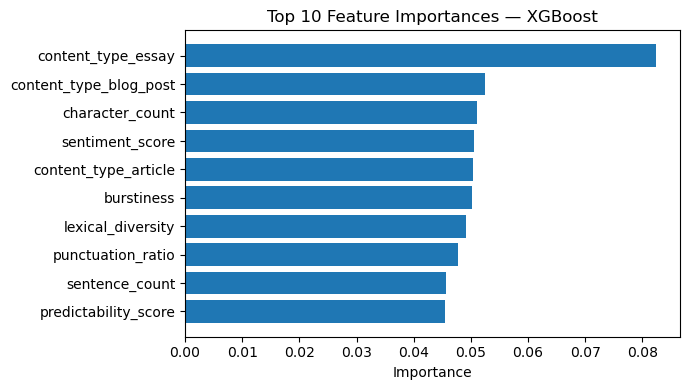

In [26]:
imp_model_name = "XGBoost" if "XGBoost" in fitted else "RandomForest"
imp_model = fitted[imp_model_name]

# Pull importances safely
if hasattr(imp_model, "feature_importances_"):
    importances = imp_model.feature_importances_
    imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
    imp_df = imp_df.sort_values("importance", ascending=False).head(10)

    plt.figure(figsize=(7,4))
    plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
    plt.xlabel("Importance")
    plt.title(f"Top 10 Feature Importances — {imp_model_name}")
    plt.tight_layout(); plt.savefig("figures/feature_importance_top10.png", dpi=150)
    plt.show()

    imp_df
else:
    print(f"{imp_model_name} does not expose feature_importances_.")

In [28]:
joblib.dump({
    "preprocessor": preprocessor,
    "best_model_name": best_name,
    "best_model": best_model
}, "final_model_bundle.joblib")

print(f"Saved final_model_bundle.joblib with preprocessor + best model: {best_name}")

conclusion = (
    "Conclusion: Using only structured writing metrics and content type (no raw text), "
    f"{best_name} achieved the best accuracy on the test set. "
    "This shows statistical writing features alone can effectively flag AI vs human content."
)
print(conclusion)

Saved final_model_bundle.joblib with preprocessor + best model: XGBoost
Conclusion: Using only structured writing metrics and content type (no raw text), XGBoost achieved the best accuracy on the test set. This shows statistical writing features alone can effectively flag AI vs human content.
